In [1]:
import cv2
import scipy
import skimage
import time

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import seaborn as sns
import SimpleITK as sitk

from scipy import sparse

from numba import vectorize, guvectorize, float32, int32, jit, cuda 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import math
from scipy import signal
from scipy.stats import entropy
from sklearn.cluster import KMeans # USAR EL DE RAPIDS

from typing import Optional

# from utils import pixel_graph, gaussian_kernel, region_extractor

### Comparing both NS mappers 

In [275]:
import cv2
import math
import scipy
import skimage

import numpy as np

from numba import jit
from scipy import signal, sparse, stats
from skimage.morphology._util import _raveled_offsets_and_distances
from skimage.util._map_array import map_array
from skimage.graph._graph import _weighted_abs_diff
from sklearn.cluster import KMeans,AgglomerativeClustering  # USAR EL DE RAPIDS
from typing import Optional, Callable
from skimage import measure
from sklearn.feature_extraction.image import grid_to_graph


def pixel_graph(
    image: np.ndarray, *, mask: np.ndarray = None, edge_function: Callable = None,
    max_g: float = None, weights_r: np.ndarray = None, weights_u: np.ndarray = None,
    ilm_image: np.ndarray = None, connectivity: int = 1, spacing: tuple = None,
    purpose: str = None
):
    """
    REFACTORED VERSION OF skimage.graph._graph.pixel_graph

    Create an adjacency graph of pixels in an image.
    Pixels where the mask is True are nodes in the returned graph, and they are
    connected by edges to their neighbors according to the connectivity
    parameter. By default, the *value* of an edge when a mask is given, or when
    the image is itself the mask, is the euclidean distance betwene the pixels.
    However, if an int- or float-valued image is given with no mask, the value
    of the edges is the absolute difference in intensity between adjacent
    pixels, weighted by the euclidean distance.
    Args:
        image (np.ndarray): The input image. If the image is of type bool,
            it will be used as the mask as well.
        mask (np.ndarray, optional): Which pixels to use. If None,
            the graph for the whole image is used.. Defaults to None.
        edge_function (Callable, optional): A function taking an array of pixel
            values, and an array of neighbor pixel values, and an array of
            distances, and returning a value for the edge. If no function
            is given, the value of an edge is just the distance. Defaults
            to None.
        max_g (float, optional): Maximum value of the image to be used to find
            the lines. Defaults to None.
        weights_r (np.ndarray, optional): Array of weigth cointaining the
            mean of the set R of pixels below each node. Defaults to None.
        weights_u (np.ndarray, optional): Array of weigth cointaining the
            mean of the set U of pixels below each node. Defaults to None.
        ilm_image (np.ndarray, optional): Boolean image with the ilm image
            detected as foreground. Defaults to None.
        connectivity (int, optional): The square connectivity of the pixel
            neighborhood: the number of orthogonal steps allowed to consider a
            pixel a neigbor. See `scipy.ndimage.generate_binary_structure`
            for details. Defaults to 1.
        spacing (int, optional): The spacing between pixels along each axis.
            Defaults to None.
        purpose (str, optional): One from: {'ilm_line','rpe_line', 'other'}.
            If None generic weights are computed from distances. Defaults
            to None.
    Returns:
        graph (scipy.sparse.csr_matrix): A sparse adjacency matrix in which
            entry (i, j) is 1 if nodes i and j are neighbors, 0 otherwise.
        nodes (np.ndarray): The nodes of the graph. These correspond to
            the raveled indices of the nonzero pixels in the mask.
    """
    if image.dtype == bool and mask is None:
        mask = image
    if mask is None and edge_function is None:
        mask = np.ones_like(image, dtype=bool)
        edge_function = _weighted_abs_diff

    # Main modification from the original version
    if mask is None and edge_function is not None:
        mask = np.ones_like(image, dtype=bool)

    padded = np.pad(mask, 1, mode='constant', constant_values=False)
    nodes_padded = np.flatnonzero(padded)
    neighbor_offsets_padded, distances_padded = _raveled_offsets_and_distances(
        padded.shape, connectivity=connectivity, spacing=spacing
    )
    neighbors_padded = nodes_padded[:, np.newaxis] + neighbor_offsets_padded
    neighbor_distances_full = np.broadcast_to(
        distances_padded, neighbors_padded.shape
    )
    nodes = np.flatnonzero(mask)
    nodes_sequential = np.arange(nodes.size)

    neighbors = map_array(neighbors_padded, nodes_padded, nodes)
    neighbors_mask = padded.reshape(-1)[neighbors_padded]
    num_neighbors = np.sum(neighbors_mask, axis=1)
    indices = np.repeat(nodes, num_neighbors)
    indices_sequential = np.repeat(nodes_sequential, num_neighbors)
    neighbor_indices = neighbors[neighbors_mask]
    neighbor_distances = neighbor_distances_full[neighbors_mask]
    neighbor_indices_sequential = map_array(
        neighbor_indices, nodes, nodes_sequential
    )

    if edge_function is None:
        data = neighbor_distances
    # Main modification 2 from the original version
    elif purpose == 'ilm_line':
        image_r = image.reshape(-1)
        weights_r_flat = weights_r.reshape(-1)
        data = edge_function(
            image_r[indices], image_r[neighbor_indices], max_g, weights_r_flat[indices]
        )
    elif purpose == 'rpe_line':
        image_r = image.reshape(-1)
        weights_r_flat = weights_r.reshape(-1)
        weights_u_flat = weights_u.reshape(-1)
        data = edge_function(
            image_r[indices], image_r[neighbor_indices], max_g, weights_r_flat[indices],
            weights_u_flat[indices], indices, ilm_image, image.shape
        )
    else:
        image_r = image.reshape(-1)
        image_r[indices]
        data = edge_function(image_r[indices], image_r[neighbor_indices], neighbor_distances)

    m = nodes_sequential.size
    mat = sparse.coo_matrix(
            (data, (indices_sequential, neighbor_indices_sequential)),
            shape=(m, m)
            )
    graph = mat.tocsr()

    return graph, nodes, indices


def gaussian_kernel(shape: tuple = (3, 3), sigma: float = 0.5):
    """
    Generates a 2D gaussian mask.
    Args:
        shape (tuple, optional): Shape of the kernel. Defaults to (3,3).
        sigma (float, optional): Std of the gaussian. Defaults to 0.5.

    Returns:
        np.ndarray: gaussian kernel
    """
    # Get the center and generate a grid of gaussian values
    m, n = [(ss-1.)/2. for ss in shape]
    y, x = np.ogrid[-m: (m + 1), -n:(n + 1)]
    h = np.exp(-(x**2 + y**2) / (2*(sigma**2)))
    # Truncate small values
    h[h < np.finfo(h.dtype).eps*h.max()] = 0
    # Renormalize after truncation
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h


def region_extractor(
    manufacturer: str, image: np.ndarray, reference: Optional[np.ndarray] = None
):
    """
    Eliminates the cero valued rows of the image and if needed, extracts
    the coarse region of the retina from an oct slice.
    Performs thresholding using the histogram of the image to define
    the best threshold and then morphological operations to eliminate
    background noise and extend the "retina" region.

    Args:
        manufacturer (str): name of the manufacturer.
            Valid ones: Topcon, Cirrus, Spectralis
        image (np.ndarray): Oct slice to be processed.
        reference (Optional[np.ndarray]): Reference image associated
            with the oct slice to be processed.
    Return:
        image (np.ndarray): Cropped version of oct slice.
        reference: If provided, cropped version of the reference image.
    """
    # Determine the threshold and the number of dilations according
    # to the manufacturer, this is obtained by experimentation
    manufacturer = manufacturer.lower()
    if manufacturer == 'topcon':
        threshold_offset = 10
        dilations = 10
    elif manufacturer == 'cirrus':
        threshold_offset = 15
        dilations = 20
    elif manufacturer == 'spectralis':
        threshold_offset = 25
        dilations = 8
#         cv2.normalize(image, image, 0, 255, cv2.NORM_MINMAX)
#         image = image.astype('uint8')
    else:
        raise ValueError(
            f'Manufacturer {manufacturer} not in the allowed ones, try again'
        )

    # Remove cero valued rows due to artifacts
    indx = np.where(np.sum(image[:, :], axis=1) > 0)
    indx_start = np.min(indx)
    indx_end = np.max(indx)
    image = image[np.min(indx):np.max(indx), :]
    if reference is not None:
        reference = reference[np.min(indx):np.max(indx), :]

    # Remove unnecesary background rows
    # Binarize
    [frec, val] = np.histogram(image, bins=30)
    thr = val[np.argmax(frec)] + threshold_offset
    mask = np.where(image > thr, 1, 0)
    # Morphological ops
    mask = skimage.morphology.erosion(mask, footprint=np.ones((5, 5)))
    mask = skimage.morphology.opening(mask)
    for i in range(dilations):
        mask = skimage.morphology.dilation(mask, footprint=np.ones((11, 11)))
    # Region extraction
    indx = np.where(np.sum(mask[:, :], axis=1) > 0)
    indx_end = np.max(indx) + indx_start
    indx_start = np.min(indx) + indx_start
    image = image[np.min(indx):np.max(indx), :]
    if reference is not None:
        reference = reference[np.min(indx):np.max(indx), :]
        return image, reference, indx_start, indx_end
    return image, indx_start, indx_end


def mean_filter(img: np.ndarray, kernel_size: int = 5):
    """
    Local mean filter
    Args:
        img (np.ndarray): image to be smoothed.
        kernel_size (int, optional): Defaults to 5.

    Returns:
        np.ndarray: filtered image.
    """
    w_val = 1/kernel_size
    con_col_matrix = np.zeros(shape=(kernel_size, 1))
    con_col_matrix = np.add(con_col_matrix, w_val)
    con_row_matrix = np.zeros(shape=(1, kernel_size))
    con_row_matrix = np.add(con_row_matrix, w_val)
    a = signal.convolve2d(img, con_col_matrix, boundary='symm', mode='same')
    return signal.convolve2d(a, con_row_matrix, boundary='symm', mode='same')


@jit(nopython=True)
def normalizer(img, minVal, maxVal):
    return (img - minVal) / (maxVal - minVal)


def ns_mapper(img: np.ndarray, inversion: bool = False):
    """
    Transform imagee to neutrosophic space, according Guo et al. 2009
    by default. If inversion is True then the inversion of T proposed
    by Rashno et al. 2017 is used.
    Args:
        img (np.ndarray): Single channel gray scale image to be transformed.
        inversion (bool): Whether to persom Rashno's inversion or not.
            Defaults to False.
    Returns:
        pns (np.ndarray): Three channels array containing T, I, and F
            NS images from img.
    """
    # Image T
    lmv = mean_filter(img)
    lmv_min = np.min(lmv)
    lmv_max = np.max(lmv)
    normalizer_func = np.vectorize(normalizer)
    T = normalizer_func(lmv, lmv_min, lmv_max)
    if inversion:
        T = 1 - T
    # Image I
    delta = np.absolute(np.array(img) - np.array(lmv))
    delta_min = np.min(delta)
    delta_max = np.max(delta)
    I_im = normalizer_func(delta, delta_min, delta_max)
    # Image F
    F = 1 - T
    # NS image
    pns = np.zeros((T.shape[0], T.shape[1], 3))
    pns[:, :, 0] = T
    pns[:, :, 1] = I_im
    pns[:, :, 2] = F
    return pns


def guo2009_ns_transform(
    img: np.ndarray, alpha: float = 0.85, beta: float = 0.85
):
    """[summary]
    One iteration of Neutrosophic Transform acording to Guo et al 2009
        with alpha mean correction and beta enhacement.
    Args:
        img (np.ndarray): Gay scale image to be transformed.
        alpha (float, optional): Alpha treshold for correction.
            Defaults to 0.85.
        beta (float, optional): Beta treshold for correction.
            Defaults to 0.85.
    Returns:
        I_entropy (float): entropy of matrix I.
        betaT (np.ndarray): Alpha mean beta enhaced version of T.
        betaI (np.ndarray): Alpha mean beta enhaced version of I.
    """
    T = img[:, :, 0]
    I_im = img[:, :, 1]

    T_shape = T.shape

    # T alpha mean
    meanT = mean_filter(T)
    alphaT = np.ones(T_shape)
    alphaT[I_im < alpha] = T[I_im < alpha]
    alphaT[I_im >= alpha] = meanT[I_im >= alpha]
    alpha_mean_T = mean_filter(alphaT)

    # I alpha mean
    mean_delta = np.absolute(alphaT - alpha_mean_T)
    mean_delta_min = np.min(mean_delta)
    mean_delta_max = np.max(mean_delta)
    normalizer_func = np.vectorize(normalizer)
    alphaI = normalizer_func(mean_delta, mean_delta_min, mean_delta_max)

    # beta enhaced T
    enhacedT = np.ones(T_shape)
    enhacedT[alphaT <= 0.5] = 2 * (enhacedT[alphaT <= 0.5] ** 2)
    enhacedT[alphaT > 0.5] = 1 - 2 * (1 - enhacedT[alphaT > 0.5]) ** 2
    betaT = np.ones(T_shape)
    betaT[alphaI < beta] = alphaT[alphaI < beta]
    betaT[alphaI >= beta] = enhacedT[alphaI >= beta]

    # beta enhaced I
    beta_mean_T = mean_filter(betaT)
    mean_delta = np.absolute(betaT - beta_mean_T)
    mean_delta_min = np.min(mean_delta)
    mean_delta_max = np.max(mean_delta)
    betaI = normalizer_func(mean_delta, mean_delta_min, mean_delta_max)

    # Entropy
    _, counts = np.unique(betaI, return_counts=True)
    I_entropy = stats.entropy(counts)
    return I_entropy, betaT, betaI


def alpha_mean_beta_enh(img: np.ndarray):
    """
    Does the alpha mean beta enhacement of neutrosophic images until
    the entropy is less than the criteria by Guo et al. 2009
    Args:
        img (np.ndarray): Neutrosophic Image MxNx3 (T, I, F)
    Returns:
        betaI_entropy (float): Entropy of image I.
        betaT (np.ndarray): Alpha mean beta enhacemed version
            of image T.
        betaI (np.ndarray): Alpha mean beta enhacemed version
            of image I.
    """
    enl = 0.00001
    err = 0.0001

    alpha = 0.85
    beta = 0.85

    while True:
        betaI_entropy, betaT, betaI = \
            guo2009_ns_transform(img, alpha, beta)
        val = (betaI_entropy-enl)/enl
        if(val < err):
            break
        else:
            enl = betaI_entropy
    return betaI_entropy, betaT, betaI


def rashno_ns_mapper(g: np.ndarray):
    """
    Transforms the image according to Rashno's proposed method.
    Args:
        g (np.ndarray): Image to tranform according to Rashno et al. 2017
            Neutrosophic Transform.
    Returns:
        T (np.ndarray): T channel of the transformed image
        I_im (np.ndarray): I channel of the transformed image
    """
    # Step 2
    NS_im = ns_mapper(g, inversion=True)
    T = NS_im[:, :, 0]
    T_shape = T.shape
    # Step 3
    kernel = gaussian_kernel((3, 9), 1)

    # Steps 4, 5, 6
    entropy = 0.00001
    while True:
        # Step 4, 5: Get FI image with the gaussian filtering
        FI = np.zeros((10, T_shape[0], T_shape[1]))
        for j in range(0, 10):
            rotated_kernel = scipy.ndimage.rotate(kernel, 18*j, reshape=True)
            FI[j, :, :] = cv2.filter2D(T, -1, rotated_kernel)

        T_FI_abs_dif = np.abs(np.repeat(np.expand_dims(T, 0), 10, 0) - FI)

        # Step 6: Get I image and Indices Ind(i,j)
        I_im = np.min(T_FI_abs_dif, axis=0)
        Ind = np.argmax(T_FI_abs_dif, axis=0)

        # Step 7 and 8
        idx = Ind[I_im >= 0.7]
        T[I_im >= 0.7] = FI[idx, I_im >= 0.7]

        # Step 9
        _, counts = np.unique(I_im, return_counts=True)
        I_entropy = stats.entropy(counts)

        if np.abs(I_entropy - entropy) > 0.001:
            entropy = I_entropy
        else:
            return T, I_im


def edge_func_ilm(
    values0: np.ndarray, values1: np.ndarray, max_g: float, mean_r: np.ndarray
):
    """
    Computes the weights of the edges of the graph to extract ILM line.
    Args:
        values0 (np.ndarray): Intensity of the pixel corresponding to each node.
        values1 (np.ndarray): Intensity of the neighbourgs of each node.
        max_g (float): Maximum value in the image from which to extract the line.
        mean_r (np.ndarray): Mean value of the 40 pixels above each node.
    Returns:
        weights (np.ndarray): Weights of all the edges.
    """
    weights = (4*max_g - values0 - values1 + 2*mean_r*max_g + 1e-5)
    normalizer_func = np.vectorize(normalizer)
    weights = normalizer_func(weights, np.min(weights), np.max(weights))
    weights = weights * 1e10 + 1e-5
    return weights


def get_path(predecessors: np.ndarray, first_node_indx: int, last_node_indx: int):
    """
    Get path from the predecessors nodes array return from the shortest path.
    Args:
        predecessors (np.ndarray): secuence of nodes in the shortest path.
        first_node_indx (int): Index of the first node in the graph.
        last_node_indx (int): Index of the last node in the graph.
    Returns:
        path (np.ndarray): path of nodes.
    """
    path = [last_node_indx]
    k = last_node_indx
    while predecessors[first_node_indx, k] != -9999:
        path.append(predecessors[first_node_indx, k])
        k = predecessors[first_node_indx, k]
    return path[::-1]


def get_ilm_line(g: np.ndarray, T: np.ndarray, r_window: int = 50):
    """
    Get the ilm line from the oct image
    Args:
        g (np.ndarray): Original OCT slice to process.
        T (np.ndarray): NS image T of image g.
        r_window (int, optional): [description]. Defaults to 50.
    Returns:
        graph_ (scipy.sparse.csr_matrix): Adjacency matrix of the graph.
        R (np.ndarray): R weights matrix.
        VerGrad (np.ndarray): Vertical gradient matrix.
        ilm_image (np.ndarray): Binary mask with the segmented line.
    """
    # Obtain Vertical Gradient Image
    H = np.transpose(np.array([[-2, 0, 2]]))
    VerGrad = scipy.signal.convolve2d(T, H, mode='same', boundary='symm')

    # Obtain R matrix with the weigths of the mean of the pixels in the
    # desired window above each node/pixel.
    kernel_r = np.ones((r_window + 1, 1)) / r_window
    kernel_r[0] = 0
    R = scipy.signal.convolve2d(
        g, kernel_r, mode='full', boundary='symm'
    )[:-r_window, :]
    normalizer_func = np.vectorize(normalizer)
    R = normalizer_func(R, np.min(R), np.max(R))

    # Padd the gradient image with intial and last columns of high values of
    # the gradient so that the weights in the graph are low there.
    pad_column = np.ones((VerGrad.shape[0], 1))
    max_T = np.max(T)  # This is the MaxG mentionned in the paper.
    VerGrad = np.concatenate([pad_column*max_T, VerGrad, pad_column*max_T], axis=1)

    # Padd the matix R with intial and last columns of very low penalties.
    R = np.concatenate([pad_column*0, R, pad_column*0], axis=1)

    # Get the graph from the pixels of the image
    graph_, _, _ = pixel_graph(
        VerGrad, edge_function=edge_func_ilm, weights_r=R, max_g=max_T,
        connectivity=2, purpose='ilm_line'
    )

    # Get the shortest path
    _, predecessors = scipy.sparse.csgraph.shortest_path(
        graph_, method='D', directed=False, return_predecessors=True,
        unweighted=False, overwrite=False, indices=([0, graph_.shape[0]-1])
    )
    path = get_path(predecessors, 0, graph_.shape[0]-1)

    # Generate a binry mask with the line
    ilm_image = np.zeros(VerGrad.shape[0] * VerGrad.shape[1])
    ilm_image[path] = 1
    ilm_image = np.reshape(ilm_image, (VerGrad.shape))

    return graph_, R, VerGrad, ilm_image


def get_distances_from_ilm_line(
    indices0: np.ndarray, ilm_image: np.ndarray, shape: tuple
):
    """
    Computes the distance of each node to the ILM line
    Args:
        indices0 (np.ndarray): Indices of the nodes.
        ilm_image (np.ndarray): Flatten version of the image with ilm line segmented.
        shape (tuple): Shape of the oct image.
    Return:
        (np.ndarray): Distance of each node to the ILM line
    """
    indices0 = np.array(indices0)
    column_indices = indices0 % ilm_image.shape[0]
    idx = np.zeros(column_indices.shape)
    for i in np.unique(indices0 % ilm_image.shape[0]):
        idx[column_indices == i] = np.max(np.where(ilm_image[:, 0]))
    row_ind = indices0 // shape[1]
    return row_ind - idx


def max_row_in_col(item):
    return np.max(np.where(item))

def rpe_flattening(
    rpe_image: np.ndarray, peak_window_size: int = 150, tr: int = 40,
    k_size: int = 101, iterations: int = 3
):
    """
    Flatten the RPE line to avoid RPE fluid accumulations.
    Args:
        rpe_image (np.ndarray): Binary image with the RPE line segmented.
        peak_window_size (int, optional):
            Size of the window to consider to find the peak. Defaults to 150.
        tr (int, optional): Size of the window to consider to find the left
            and right points. Defaults to 40.
        k_size (int, optional): Size of the filter to use for smoothing.
            Defaults to 101.
        iterations (int, optional):
            Number of times to perfor the flattening. Defaults to 3.
    Returns:
        new_rpe (np.ndarray): Corrected line.
        original_line (np.ndarray): Original line.
        indx (np.ndarray): x coordinates of the line.
        pick_start (int): Left point.
        pick (int): Central point.
        pick_end (int): Right point.
    """
    # Get the line (i,j) coordinates
    rpe_line = np.apply_along_axis(max_row_in_col, axis=0, arr=rpe_image[:, 1:-1])
    # Inverted to see them "from below"
    original_line = rpe_image.shape[0] - rpe_line
    new_line = original_line.copy()
    
    # Repeat the seek for peaks the required times
    for it in range(iterations):
        rpe = new_line.copy()
        # Smooth the line with mean filtering to avoid sharp small peaks
        l_rpe = len(rpe)
        kernel = np.ones(k_size)/(k_size)
        rpe = scipy.signal.convolve(rpe, kernel, mode='valid')

        # Get the maximum curvature point in the line
        l_rpe = len(rpe)  # size changed after filtering
        curvature = np.zeros(l_rpe)
        for i in range(peak_window_size, l_rpe-peak_window_size):
            L, R = 0, 0
            for j in range(peak_window_size):
                left_w = (i-j) if (i-j) >= 0 else 0
                right_w = (i+j) if (i+j) < l_rpe else i
                L += rpe[i] - rpe[left_w]
                R += rpe[i] - rpe[right_w]
            curvature[i] = L + R
        pick = np.argmax(curvature)

        # Get the left point value
        curr = pick
        c = True
        while c:
            if (curr - tr) < 0:
                c = False
                curr = 0
            elif rpe[curr] > rpe[(curr - tr)]:
                curr = curr - 1
            else:
                c = False
            pick_start = curr

        # Get the right point value
        curr = pick.copy()
        c = True
        while c:
            if (curr + tr) >= len(rpe):
                c = False
                curr = len(rpe)-1
            elif rpe[curr] > rpe[(curr + tr)]:
                curr = curr + 1
            else:
                c = False
            pick_end = curr

        # Get the original positions (considering change of size of filtering)
        pick_start = int(pick_start + ((k_size-1)/2))
        pick = int(pick + ((k_size-1)/2))
        pick_end = int(pick_end + ((k_size-1)/2))

        # If no peak is found, quit
        if (pick_end == pick) and (pick_start == pick):
            break
        else:
            # Interpolate line
            slope = (original_line[pick_end] - original_line[pick_start])/(pick_end - pick_start)
            new_values = np.arange(0, pick_end - pick_start) * slope + original_line[pick_start]
            new_line[pick_start:pick_end] = new_values

    # Generate mask
    new_rpe = np.zeros(rpe_image.shape)
    new_rpe[rpe_image.shape[0] - new_line, np.arange(0, len(original_line))] = 1
    new_rpe = np.where(new_rpe, 1, 0)

    return new_rpe, original_line, pick_start, pick, pick_end

def edge_func_rpe(
    values0: np.ndarray, values1: np.ndarray, max_g: float, mean_r: np.ndarray,
    mean_u: np.ndarray, indices0: np.ndarray, ilm_image: np.ndarray, shape: tuple
):
    """
    Computes the weights of the edges of the graph to extract RPE line.
    Args:
        values0 (np.ndarray): Intensity of the pixel corresponding to each node.
        values1 (np.ndarray): Intensity of the neighbourgs of each node.
        max_g (float): Maximum value in the image from which to extract the line.
        mean_r (np.ndarray): Mean values of the R pixels above each node.
        mean_u (np.ndarray): Mean values of the U pixels below each node.
        indices0 (np.ndarray): Indices of the nodes.
        ilm_image (np.ndarray): Flatten version of the image with ilm line segmented.
        shape (tuple): shape of the oct image.
    Returns:
        weights (np.ndarray): Weights of all the edges.
    """
    D = get_distances_from_ilm_line(indices0, ilm_image, shape)
    gradient_term = 4 * max_g - values0 - values1
    weights = 8*gradient_term - 2*mean_u*max_g - D*4e-3 + 2*(1 - mean_r)*max_g
    normalizer_func = np.vectorize(normalizer)
    weights = normalizer_func(weights, np.min(weights), np.max(weights))
    weights = weights * 1e10 + 1e-5
    return weights


def get_rpe_line(
    g: np.ndarray, T: np.ndarray, ilm_image: np.ndarray,
    r_window: int = 150, u_window: int = 20
):
    """
    Get the RPE line from the oct image
    Args:
        g (np.ndarray): Original OCT slice to process.
        T (np.ndarray): NS image T of image g.
        ilm_image (np.ndarray): Binary image with ilm line segmented.
        r_window (int, optional): Size of the R window. Defaults to 50.
        u_window (int, optional): Size of the U window. Defaults to 10.
    Returns:
        graph_ (scipy.sparse.csr_matrix): Adjacency matrix of the graph.
        R (np.ndarray): R weights matrix.
        U (np.ndarray): U weights matrix.
        VerGrad (np.ndarray): Vertical gradient matrix.
        rpe_image (np.ndarray): Binary mask with the segmented line.
        indices (np.ndarray): Node indices over the segmented line.
    """
    # Obtain Vertical Gradient Image
    H = np.transpose(np.array([[2, 0, -2]]))
    VerGrad = scipy.signal.convolve2d(T, H, mode='same', boundary='symm')
    # Padd the gradient image with intial and last columns of high values of
    # the gradient so that the weights in the graph are low there.
    pad_column = np.ones((VerGrad.shape[0], 1))
    max_T = np.max(T)  # This is the MaxG mentionned in the paper.
    VerGrad = np.concatenate([pad_column*max_T, VerGrad, pad_column*max_T], axis=1)

    # Obtain R matrix with the weigths of the mean of the pixels in the
    # desired window above each node/pixel.
    kernel = np.ones((r_window + 1, 1)) / r_window
    kernel[0] = 0
    R = scipy.signal.convolve2d(
        g, kernel, mode='full', boundary='symm'
    )[:-r_window, :]
    normalizer_func = np.vectorize(normalizer)
    R = normalizer_func(R, np.min(R), np.max(R))
    # Padd the matix R with intial and last columns of penalties of 1 which
    # are going to turn zero after invertion.
    R = np.concatenate([pad_column*1, R, pad_column*1], axis=1)

    # Obtain the matrix containing all the penalizations to the weights of the image
    kernel = np.ones((u_window + 1, 1)) / u_window
    kernel[-1] = 0
    U = scipy.signal.convolve2d(g, kernel, boundary='fill', fillvalue=0)[u_window:, :]
    U = normalizer_func(U, np.min(U), np.max(U))
    # Add a new first and last column with high values (low penalties).
    U = np.concatenate([pad_column, U, pad_column], axis=1)

    # Get the graph from the pixels of the image
    graph_, nodes, indices = pixel_graph(
        VerGrad, edge_function=edge_func_rpe, max_g=max_T, weights_r=R,
        weights_u=U, ilm_image=ilm_image, connectivity=1, purpose='rpe_line'
    )

    # Get the shortest path
    _, predecessors = scipy.sparse.csgraph.shortest_path(
        graph_, method='D', directed=False, return_predecessors=True,
        unweighted=False, overwrite=False, indices=([0, graph_.shape[0]-1])
    )
    path = get_path(predecessors, 0, graph_.shape[0]-1)

    # Generate a binry mask with the line
    rpe_image = np.zeros(VerGrad.shape[0] * VerGrad.shape[1])
    rpe_image[path] = 1
    rpe_image = np.reshape(rpe_image, (VerGrad.shape))

    return graph_, R, U, VerGrad, rpe_image, indices


def get_retina_mask(ilm_image_fill: np.ndarray, rpe_image_fill: np.ndarray, alt=False):
    """
    Get binary mask of the retina region between ILM and RPE lines.
    Args:
        ilm_image_fill (np.ndarray): [description]
        rpe_image_fill (np.ndarray): [description]
    Returns:
        np.ndarray: Binary mask of the retina region between ILM and RPE lines.
    """
    # ILM mask
    if alt:
        indx = np.min(np.where(ilm_image_fill[:,1:-1] == 1)[0])
        ilm_image_fill[indx:, :] = 1
    else:
        for i in range(ilm_image_fill.shape[1]):
            indx = np.max(np.where(ilm_image_fill[:, i] == 1)[0])
            ilm_image_fill[indx:, i] = 1
    # RPE mask
    for i in range(rpe_image_fill.shape[1]):
        try:
            indx = np.max(np.where(rpe_image_fill[:, i] == 1)[0])
            rpe_image_fill[indx:, i] = 1
        except Exception as e:
            pass
    return np.where(ilm_image_fill-rpe_image_fill, 1, 0)[:, 1:-1]


def clustering(img: np.ndarray, mask: np.ndarray, n_clusters: int = 5, algo: str='kmeans'):
    """
    Args:
        img (np.ndarray): Image which pixels are going to be clustered.
        mask (np.ndarray): Binary mask to select the pixels.
        n_clusters (int, optional): Number of clusters to find. Defaults to 5.
    Returns:
        result (np.ndarray): Image with cluster labels.
    """
    ary = img[np.where(mask, True, False)].reshape(-1, 1)
    if algo == 'kmeans':
         algorithm = KMeans(n_clusters=n_clusters, random_state=0)
    else:    
        s = img.shape
        connectivity = grid_to_graph(*s, mask=mask)
        algorithm = AgglomerativeClustering(
            n_clusters=n_clusters, linkage='ward', connectivity=connectivity
        )
    
    clusters = algorithm.fit_predict(ary)
    result = np.zeros(img.shape)
    result[np.where(mask, True, False)] = clusters+1
    return result


def select_seeds(
    img: np.ndarray, clust_result: np.ndarray, FN: int = 500,
    TN: int = 700, n_clust_object: int = 2
):
    """
    Sample seeds from the fluid and retina regions acording to the procedure
    described in Rashno et al. 2017
    Args:
        img (np.ndarray): Image from where to sample the seeds.
        clust_result (np.ndarray): Image from with the clustering labels.
        FN (int, optional): Number of fluid points to sample. Defaults to 500.
        TN (int, optional): Number of ratina points to sample. Defaults to 700.
        n_clust_object (int, optional): number of clusters assigned to fluid.
    Returns:
        fluid_seeds, retina_seeds
    """
    n_clust = len(np.unique(clust_result)) - 1
    clusters_centers = []
    for i in range(1, n_clust+1):
        clusters_centers.append(np.mean(img[clust_result == i]))
    clusters_centers = np.array(clusters_centers)
    indices = np.flip(np.argsort(clusters_centers)) + 1
    
    # Fluid Seeds
    fluid_condition = (clust_result == indices[0])
    for i in range(n_clust_object):
        fluid_condition = fluid_condition | (clust_result == indices[i])
    potential_seeds = np.array(np.where(fluid_condition)).T
    sample_indx = np.random.randint(0, potential_seeds.shape[0], FN)
    fluid_seeds = potential_seeds[sample_indx]

    # Retina Seeds:
    # Get sampling probabilities and number of samples per cluster
    pi = 1/(2**np.arange(1, n_clust-n_clust_object+1))
    Npi = np.ones((n_clust-n_clust_object))*70
    pre_asigned = (n_clust-n_clust_object)*70
    Npi = Npi + np.round((pi/np.sum(pi))*(700-pre_asigned))
    Npi = Npi.astype('int')
#     Npi = (np.ones((n_clust-n_clust_object))*(700 / n_clust)).astype('int')
    # Sample seeds
    retina_seeds = []
    for i in range(n_clust_object, len(indices)):
        bkg_condition = (clust_result == indices[i])
        potential_seeds = np.array(np.where(bkg_condition)).T
        sample_indx = \
            np.random.randint(0, potential_seeds.shape[0], Npi[i-n_clust_object])
        retina_seeds.append(potential_seeds[sample_indx])
    retina_seeds = np.concatenate(retina_seeds)
    return fluid_seeds, retina_seeds, clusters_centers, indices


def Bpq(
    values0: np.ndarray, values1: np.ndarray, distances: np.ndarray,
    scaling: int = 1, sigma: float = (30/255)
):
    """
    Computes the Bpq weights of the edges of the graph for graph cut.
    Args:
        values0 (np.ndarray): Intensity of the pixel corresponding to each node.
        values1 (np.ndarray): Intensity of the neighbourgs of each node.
        distances (np.ndarray): Distances between nodes.
        scaling (int, optional): Scaling factor "k". Defaults to 2.
        sigma (float, optional): Sigma involved in the weights.
            Defaults to (30/255).
    Returns:
        weights (np.ndarray): Weights of all the edges.
    """
    exponential_part = np.exp(-((values0 - values1)**2)/(2*(sigma**2)))
    weigths = scaling * exponential_part * (1/distances) + 1e-5
    return weigths


@jit(nopython=True)
def R1p(item: np.ndarray, mean: float, sigma: float):
    """
    Get the R1p values according to Rashno et al. 2017
    Args:
        item (np.ndarray)
        mean (float)
        sigma (float)
    """
    return 2 - 2 * math.exp(-((item - mean)**2) / (2*(sigma**2)))


def regional_term(
    img: np.ndarray, obj_seeds: np.ndarray, bkg_seeds: np.ndarray,
    I_img: np.ndarray, region: str = 'object'
):
    """
    Extract the regional weights from the energy function for the graph cut
    Args:
        img (np.ndarray): Image to use to compute the weights.
        obj_seeds (np.ndarray): Positions of the fluid seeds.
        bkg_seeds (np.ndarray): Positions of the background seeds.
        I_img (np.ndarray): Idederminancy matrix.
        region (str, optional): Options 'object', 'background'.
            Defaults to 'object'.
    Returns:
        Rp (np.ndarray): Regional weights.
        R1p_obj (np.ndarray): Object R1p regional weights
        R1p_bkg (np.ndarray): Background R1p regional weights
    """
    R1p_func = np.vectorize(R1p)
    # Get means of seeds
    mean_obj = np.mean(img[obj_seeds[:, 0], obj_seeds[:, 1]])
    mean_bkg = np.mean(img[bkg_seeds[:, 0], bkg_seeds[:, 1]])
    # Get R1p matrices for object and bkg
    R1p_obj = R1p_func(img, mean_obj, 0.1)
    R1p_bkg = R1p_func(img, mean_bkg, 0.1)

    # Get Rp matrix
    Rp = np.zeros(img.shape)
    first_term = np.zeros(img.shape)
    second_term = np.zeros(img.shape)
    if region == 'object':
        first_term[R1p_obj > R1p_bkg] = \
            (1 - I_img[R1p_obj > R1p_bkg]) * R1p_obj[R1p_obj > R1p_bkg]
        first_term[R1p_obj <= R1p_bkg] = 1
        second_term[R1p_bkg > R1p_obj] = R1p_obj[R1p_bkg > R1p_obj]
        second_term[R1p_bkg <= R1p_obj] = 1
    else:
        first_term[R1p_obj < R1p_bkg] = \
            (1 - I_img[R1p_obj < R1p_bkg]) * R1p_bkg[R1p_obj < R1p_bkg]
        first_term[R1p_obj >= R1p_bkg] = 1
        second_term[R1p_bkg < R1p_obj] = R1p_bkg[R1p_bkg < R1p_obj]
        second_term[R1p_bkg >= R1p_obj] = 1
    Rp = first_term * second_term
    return Rp, R1p_obj, R1p_bkg


def get_graph_flow_adj_matrix(
    img: np.ndarray, mask: np.ndarray, I_im: np.ndarray, obj_seeds: np.ndarray,
    bkg_seeds: np.ndarray, lamda1: int = 1e12, lamda2: int = 1e8,
    directed: bool = False
):
    """
    Generates the adjacency matrix for doing the min cut from masked area of image img,
    usign the indicated seed for object and background as hard constraints.
    Args:
        img (np.ndarray): Image to construct the graph from.
        mask (np.ndarray): Binary image indicating which pixels
            should be considered.
        I_im (np.ndarray): Indeterminancy matrix from NS.
        obj_seeds (np.ndarray): Coordinates of seeds for the object region.
        bkg_seeds (np.ndarray): Coordinates of seeds for the background region.
        lamda1 (int, optional): Weight for the regional term in energy function.
            Defaults to 1e12.
        lamda2 (int, optional): Weight for the boundary term in energy function.
            Defaults to 1e8.
        directed (bool, optional): Wether to use a directed graph or not.
            Defaults to False.
    Returns:
        graph_ (scipy.sparse.csr_matrix): Adjacency matrix.
        nodes (np.ndarray): Node's indices in the graph.
    """
    # Get regional weights
    reg_term_obj, _, _ = \
        regional_term(img, obj_seeds, bkg_seeds, I_im, region='object')
    reg_term_bkg, _, _ = \
        regional_term(img, obj_seeds, bkg_seeds, I_im, region='background')

    # Get the portion of the graph corresponding to the neighbourhood edges
    # with Bpq weights
    graph_, nodes, _ = pixel_graph(
        img, mask=np.where(mask, True, False), connectivity=2, edge_function=Bpq
    )

    # Get the fluid seeds positions amond the nodes
    obj_seeds_positions = np.zeros(img.shape)
    obj_seeds_positions[obj_seeds[:, 0], obj_seeds[:, 1]] = 1
    obj_seeds_positions = obj_seeds_positions.flatten()
    obj_seeds_positions = obj_seeds_positions[nodes]
    obj_seeds_positions = np.where(obj_seeds_positions, True, False)

    # Get the bkg seeds positions amond the nodes
    bgk_seeds_positions = np.zeros(img.shape)
    bgk_seeds_positions[bkg_seeds[:, 0], bkg_seeds[:, 1]] = 1
    bgk_seeds_positions = bgk_seeds_positions.flatten()
    bgk_seeds_positions = bgk_seeds_positions[nodes]
    bgk_seeds_positions = np.where(bgk_seeds_positions, True, False)

    # Get the K value for the weights according to
    # Boykov et al. 2006 table in section 2.5
    max_weights_for_node = 1 + np.max(np.sum(graph_, axis=1))

    # Weights with the Source
    weigthsS = (reg_term_bkg).flatten()[nodes]
    weigthsS[obj_seeds_positions] = max_weights_for_node
    weigthsS[bgk_seeds_positions] = 0

    # Weights with the Terminal(sink)
    weigthsT = (reg_term_obj).flatten()[nodes]
    weigthsT[bgk_seeds_positions] = max_weights_for_node
    weigthsT[obj_seeds_positions] = 0

    # Apply scaling factors to the weights
    weigthsT = (lamda1*weigthsT).reshape(-1, 1)
    weigthsS = (lamda1*weigthsS).reshape(-1, 1)
    graph_ = lamda2*graph_

    # Add source and terminal nodes and weights with themself
    nodes_ = np.insert(nodes+1, 0, 0)
    nodes_ = np.append(nodes_, nodes_[-1]+1)

    # Append the source and sink relations in the adjacency matrix
    graph_ = scipy.sparse.vstack(
        [scipy.sparse.csr_matrix(weigthsS.T),
         graph_,
         scipy.sparse.csr_matrix(weigthsT.T)]
    )
    weigthsT = \
        np.append(np.insert(weigthsT.flatten(), 0, 0), 0).reshape(-1, 1)
    weigthsS = \
        np.append(np.insert(weigthsS.flatten(), 0, 0), 0).reshape(-1, 1)
    graph_ = scipy.sparse.hstack(
        [scipy.sparse.csr_matrix(weigthsS),
         graph_,
         scipy.sparse.csr_matrix(weigthsT)]
    )

    # If directed graph is request:
    if directed:
        graph_ = scipy.sparse.triu(graph_)
    graph_ = scipy.sparse.csr_matrix(graph_.astype(int))
    return graph_, nodes


def image_from_minimum_cut(partition: tuple, shape: tuple, nodes: np.ndarray):
    """
    Generate a binary image of the resulting segmentation from the graph cut
    Args:
        partition (tuple): Result from nx.minimum_cut algorithm.
        shape (tuple): shape of the desired image.
        nodes (np.ndarray): Nodes indices present in the graph
    Returns:
        segmentation (np.ndarray): Binary image with the resulting segmentation.
    """
    object_, background = partition
    length = shape[0] * shape[1]
    segmentation = np.zeros(length)
    obj_nodes = np.array(list(object_))
    obj_nodes = np.delete(obj_nodes, np.where((obj_nodes==0)|(obj_nodes==len(nodes)+1)))
    obj_nodes -= 1
    bkg_nodes = np.array(list(background))
    bkg_nodes = np.delete(bkg_nodes, np.where((bkg_nodes==0)|(bkg_nodes==len(nodes)+1)))
    bkg_nodes -= 1
    segmentation[nodes[obj_nodes]] = 1
    segmentation = np.reshape(segmentation, shape)
    return segmentation


def preprocessing(manufacturer: str, im: np.ndarray, ref: np.ndarray, spacing: tuple):
    im, ref, indx_start, indx_end = region_extractor(manufacturer, im, ref)
    im = scipy.ndimage.zoom(im, (1, spacing[0]/spacing[1]), order=3, mode='reflect', prefilter=False)
    ref = scipy.ndimage.zoom(ref, (1, spacing[0]/spacing[1]), order=0, mode='reflect', prefilter=False)
    if manufacturer=='Spectralis':
        cv2.normalize(im, im, 0, 255, cv2.NORM_MINMAX)
        im = im.astype('uint8')
        im = cv2.bilateralFilter(src=im, d=10, sigmaColor=200, sigmaSpace=2)
    return im, ref, indx_start, indx_end


def post_processing(segmentation, T_am_be, retina_mask, indices, Tr=50):
    
    selection = (
        (result_clust == indices[0])|(result_clust == indices[1])|
        (result_clust == indices[2])|(result_clust == indices[3])
    )
    mean_intensity = np.mean(T_am_be[selection])
    segm = T_am_be*retina_mask*(segmentation)
    segm = np.where(segm<mean_intensity, 0, 1)
    foot = np.array([[0,1,0],[1,1,1],[0,1,0]])
    ero = skimage.morphology.opening(segm, footprint=foot)
    labels, num = skimage.measure.label(ero, background=0, return_num=True)
    label, counts = np.unique(labels, return_counts=True)
    label = label[np.where(counts>Tr)]
    final = np.zeros(labels.shape)
    for i in label:
        a = np.unique(segmentation[labels==i])
        final[labels==i] = a[0]
    ero = skimage.morphology.erosion(retina_mask, footprint=foot)
    final = ero*final
    final = skimage.morphology.dilation(segm, footprint=foot)
    return final
    
def save_segmentation(segmentation, ref_itkimage, filename):
    origin = ref_itkimage.GetOrigin()
    spacing = ref_itkimage.GetSpacing()
    segmentation = sitk.GetImageFromArray(segmentation, isVector=False)
    segmentation.SetSpacing(spacing)
    segmentation.SetOrigin(origin)
    sitk.WriteImage(segmentation, filename)

In [272]:
import pandas as pd

Slice: 0


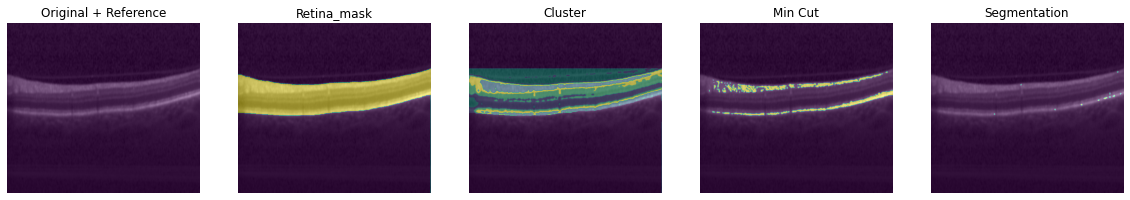

Dice:  0.0
Slice: 1


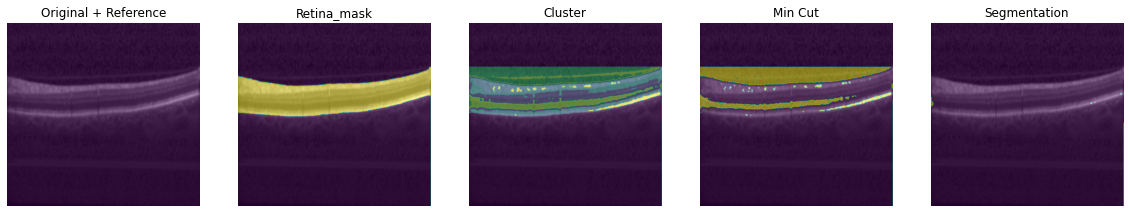

Dice:  0.0
Slice: 2


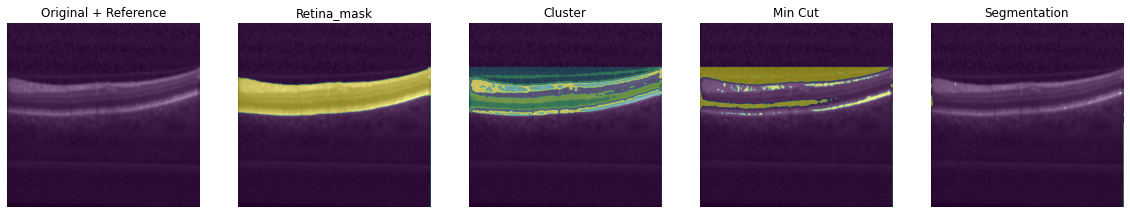

Dice:  0.0
Slice: 3


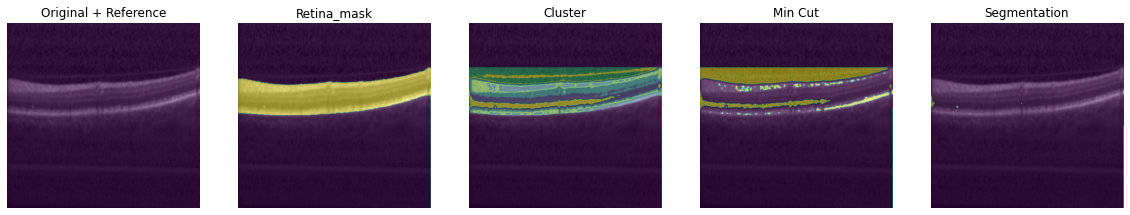

Dice:  0.0
Slice: 4


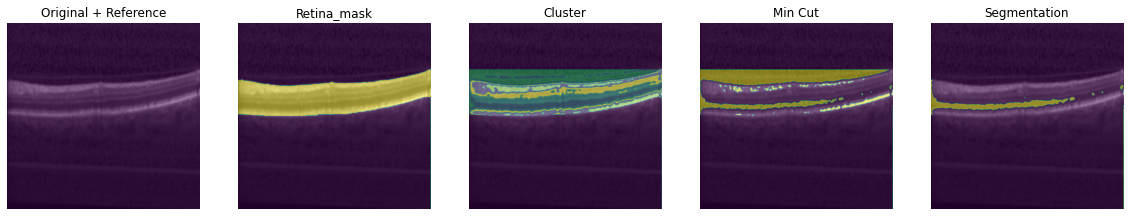

Dice:  0.0
Slice: 5


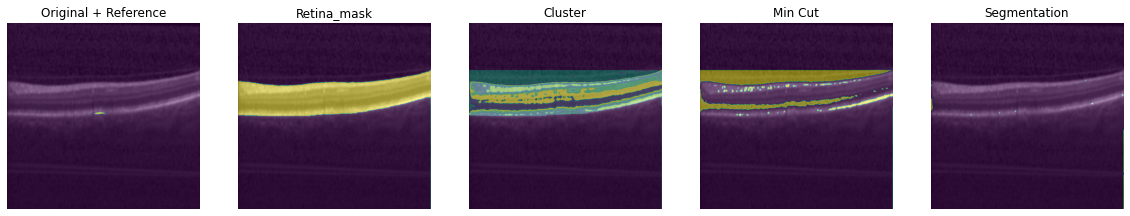

Dice:  0.0
Slice: 6


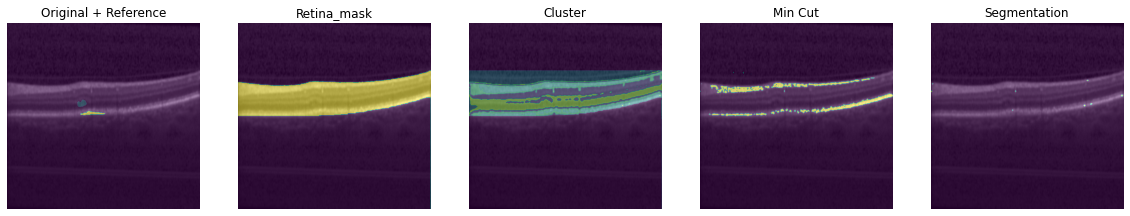

Dice:  0.0
Slice: 7


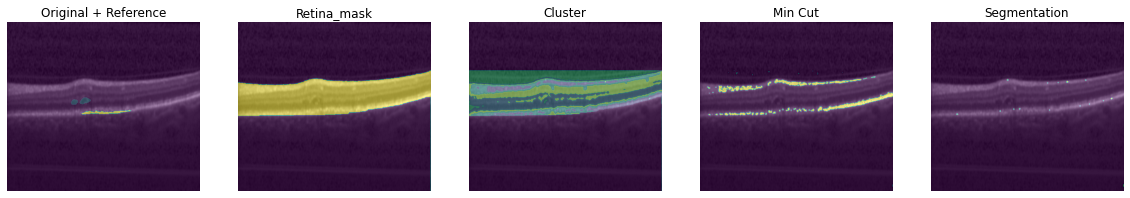

Dice:  0.0
Slice: 8


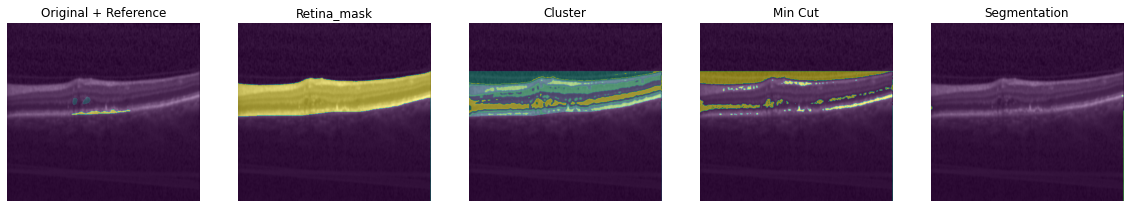

Dice:  0.0
Slice: 9


In [ ]:
for i in range(25,49):
    case = f'TRAIN0{i}'
    # Image Loading:
    manufacturer = 'Spectralis'
    itkimage = sitk.ReadImage(f'../data/RETOUCH-TrainingSet-Spectralis/{case}/oct.mhd')
    ref_itkimage = sitk.ReadImage(f'../data/RETOUCH-TrainingSet-Spectralis/{case}/reference.mhd')

    oct_scan = sitk.GetArrayFromImage(itkimage)
    ref_oct_scan = sitk.GetArrayFromImage(ref_itkimage)

    dices = pd.DataFrame(columns = ['case', 'slice', 'dice'])

    spacing = itkimage.GetSpacing()
    complete_segmentation = np.zeros(ref_oct_scan.shape)
    for j in range(0,49):
        print(f'Slice: {j}')
        slice_ = j
        # Preprocess:
        # GUARDAR SIZE Y POSICIONES ORIGINALES PARA RECONSTRUIR TAMAÑO ORIGINAL A LA SALIDA
        im, ref, indx_start, indx_end = preprocessing(
            manufacturer, oct_scan[slice_, :, :], ref_oct_scan[slice_, :, :], itkimage.GetSpacing()
        )
        # Get the NS tranform
        T, I = rashno_ns_mapper(im)

        # Get ILM line
        _, R, V, ilm_image = get_ilm_line(im, T, r_window=50)

        # Get RPE line and flatten()
        _, R, U, _, rpe_image, indices = get_rpe_line(im, T, ilm_image, r_window=150, u_window=20)

        rpe_image, _, _, _, _ = \
            rpe_flattening(rpe_image, peak_window_size=500, tr=80, k_size=101, iterations=3)
        retina_mask = get_retina_mask(ilm_image.copy(), rpe_image.copy())

        alt_retina_mask = get_retina_mask(ilm_image.copy(), rpe_image.copy(), alt=True)

        rel = spacing[1]/spacing[0]
        im = scipy.ndimage.zoom(im, (1, rel), order=3, mode='reflect', prefilter=False)
        ref = scipy.ndimage.zoom(ref, (1, rel), order=0, prefilter=False)
        retina_mask = scipy.ndimage.zoom(retina_mask, (1, rel), order=0, prefilter=False)
        alt_retina_mask = scipy.ndimage.zoom(alt_retina_mask, (1, rel), order=0, prefilter=False)

        # Neutrosophic transform
        im_NS = ns_mapper(im, inversion=True)
        _, T_am_be, betaI = alpha_mean_beta_enh(im_NS)

        #Kmeans clustering
        result_clust = clustering(T_am_be, alt_retina_mask, 6)

        # Sample the seeds
        fluid_seeds, bkg_seeds, clusters_centers, indices = \
            select_seeds(T_am_be, result_clust, FN=500, TN=700, n_clust_object=1)
        indices = indices-1
        k = (clusters_centers[indices[0]]-clusters_centers[indices[1]]) / clusters_centers[indices[0]]
        rel_clust_cent_1_2.append(k)
        k = (clusters_centers[indices[0]]-clusters_centers[indices[2]]) / clusters_centers[indices[0]]
        rel_clust_cent_1_3.append(k)

        # Obtain the full weigthed graph
        graph_, nodes = get_graph_flow_adj_matrix(
            T_am_be, alt_retina_mask, betaI, fluid_seeds,
            bkg_seeds, lamda1=1e12, lamda2=1e8, directed=False
        )

        # Get mincut
        G = nx.from_scipy_sparse_matrix(graph_, create_using=nx.Graph, edge_attribute='capacity')
        cut_value, partition = nx.minimum_cut(G, 0, graph_.shape[0]-1)

        min_cut = image_from_minimum_cut(partition, T_am_be.shape, nodes)

        segmentation = post_processing(min_cut, T_am_be, retina_mask, indices, Tr=50)

        plots2(im, ref, retina_mask, result_clust, min_cut, segmentation)

        complete_segmentation[slice_, indx_start:indx_end, :] = segmentation

        ground_truth = np.where(ref!=0,1,0)
        dice = np.sum(segmentation[ground_truth==1])*2.0 / (np.sum(ground_truth) + np.sum(segmentation))
        print('Dice: ', dice)
        row = {'case': case, 'slice': slice_, 'dice': dice}
        dices = dices.append(row, ignore_index=True)
        dices.to_csv(
            '/home/joaquin/Desktop/MAIA/Clases/image-processing/project/image-processing-project/dices.csv'
        )

    filename = f'../data/RETOUCH-TrainingSet-Spectralis/{case}/segmentation.mhd'
    save_segmentation(complete_segmentation, ref_itkimage, filename)

In [ ]:
for i in range(49,71):
    case = f'TRAIN0{i}'
    # Image Loading:
    manufacturer = 'Topcon'
    itkimage = sitk.ReadImage(f'../data/RETOUCH-TrainingSet-Topcon/{case}/oct.mhd')
    ref_itkimage = sitk.ReadImage(f'../data/RETOUCH-TrainingSet-Topcon/{case}/reference.mhd')

    oct_scan = sitk.GetArrayFromImage(itkimage)
    ref_oct_scan = sitk.GetArrayFromImage(ref_itkimage)

    dices_ = pd.DataFrame(columns = ['case', 'slice', 'dice'])

    spacing = itkimage.GetSpacing()
    complete_segmentation = np.zeros(ref_oct_scan.shape)
    for j in range(0,49):
        print(f'Slice: {j}')
        slice_ = j
        # Preprocess:
        # GUARDAR SIZE Y POSICIONES ORIGINALES PARA RECONSTRUIR TAMAÑO ORIGINAL A LA SALIDA
        im, ref, indx_start, indx_end = preprocessing(
            manufacturer, oct_scan[slice_, :, :], ref_oct_scan[slice_, :, :], itkimage.GetSpacing()
        )
        # Get the NS tranform
        T, I = rashno_ns_mapper(im)

        # Get ILM line
        _, R, V, ilm_image = get_ilm_line(im, T, r_window=50)

        # Get RPE line and flatten()
        _, R, U, _, rpe_image, indices = get_rpe_line(im, T, ilm_image, r_window=150, u_window=20)

        rpe_image, _, _, _, _ = \
            rpe_flattening(rpe_image, peak_window_size=500, tr=80, k_size=101, iterations=3)
        retina_mask = get_retina_mask(ilm_image.copy(), rpe_image.copy())

        alt_retina_mask = get_retina_mask(ilm_image.copy(), rpe_image.copy(), alt=True)

        rel = spacing[1]/spacing[0]
        im = scipy.ndimage.zoom(im, (1, rel), order=3, mode='reflect', prefilter=False)
        ref = scipy.ndimage.zoom(ref, (1, rel), order=0, prefilter=False)
        retina_mask = scipy.ndimage.zoom(retina_mask, (1, rel), order=0, prefilter=False)
        alt_retina_mask = scipy.ndimage.zoom(alt_retina_mask, (1, rel), order=0, prefilter=False)

        # Neutrosophic transform
        im_NS = ns_mapper(im, inversion=True)
        _, T_am_be, betaI = alpha_mean_beta_enh(im_NS)

        #Kmeans clustering
        result_clust = clustering(T_am_be, alt_retina_mask, 6)

        # Sample the seeds
        fluid_seeds, bkg_seeds, clusters_centers, indices = \
            select_seeds(T_am_be, result_clust, FN=500, TN=700, n_clust_object=1)
        indices = indices-1
        k = (clusters_centers[indices[0]]-clusters_centers[indices[1]]) / clusters_centers[indices[0]]
        rel_clust_cent_1_2.append(k)
        k = (clusters_centers[indices[0]]-clusters_centers[indices[2]]) / clusters_centers[indices[0]]
        rel_clust_cent_1_3.append(k)

        # Obtain the full weigthed graph
        graph_, nodes = get_graph_flow_adj_matrix(
            T_am_be, alt_retina_mask, betaI, fluid_seeds,
            bkg_seeds, lamda1=1e12, lamda2=1e8, directed=False
        )

        # Get mincut
        G = nx.from_scipy_sparse_matrix(graph_, create_using=nx.Graph, edge_attribute='capacity')
        cut_value, partition = nx.minimum_cut(G, 0, graph_.shape[0]-1)

        min_cut = image_from_minimum_cut(partition, T_am_be.shape, nodes)

        segmentation = post_processing(min_cut, T_am_be, retina_mask, indices, Tr=50)

        plots2(im, ref, retina_mask, result_clust, min_cut, segmentation)

        complete_segmentation[slice_, indx_start:indx_end, :] = segmentation

        ground_truth = np.where(ref!=0,1,0)
        dice = np.sum(segmentation[ground_truth==1])*2.0 / (np.sum(ground_truth) + np.sum(segmentation))
        print('Dice': dice)
        row = {'case': case, 'slice': slice_, 'dice': dice}
        dices_ = dices.append(row, ignore_index=True)
        dices_.to_csv('../dices_topcon.csv')

    filename = f'../data/RETOUCH-TrainingSet-Topcon/{case}/segmentation.mhd'
    save_segmentation(complete_segmentation, ref_itkimage, filename)

In [ ]:
for i in range(49,71):
    number = f'{i}' if i >= 10 else f'0{i}'
    case = f'TRAIN0{i}'
    # Image Loading:
    manufacturer = 'Cirrus'
    itkimage = sitk.ReadImage(f'../data/RETOUCH-TrainingSet-Cirrus/{case}/oct.mhd')
    ref_itkimage = sitk.ReadImage(f'../data/RETOUCH-TrainingSet-Cirrus/{case}/reference.mhd')

    oct_scan = sitk.GetArrayFromImage(itkimage)
    ref_oct_scan = sitk.GetArrayFromImage(ref_itkimage)

    dices_ = pd.DataFrame(columns = ['case', 'slice', 'dice'])

    spacing = itkimage.GetSpacing()
    complete_segmentation = np.zeros(ref_oct_scan.shape)
    for j in range(0,49):
        print(f'Slice: {j}')
        slice_ = j
        # Preprocess:
        # GUARDAR SIZE Y POSICIONES ORIGINALES PARA RECONSTRUIR TAMAÑO ORIGINAL A LA SALIDA
        im, ref, indx_start, indx_end = preprocessing(
            manufacturer, oct_scan[slice_, :, :], ref_oct_scan[slice_, :, :], itkimage.GetSpacing()
        )
        # Get the NS tranform
        T, I = rashno_ns_mapper(im)

        # Get ILM line
        _, R, V, ilm_image = get_ilm_line(im, T, r_window=50)

        # Get RPE line and flatten()
        _, R, U, _, rpe_image, indices = get_rpe_line(im, T, ilm_image, r_window=150, u_window=20)

        rpe_image, _, _, _, _ = \
            rpe_flattening(rpe_image, peak_window_size=500, tr=80, k_size=101, iterations=3)
        retina_mask = get_retina_mask(ilm_image.copy(), rpe_image.copy())

        alt_retina_mask = get_retina_mask(ilm_image.copy(), rpe_image.copy(), alt=True)

        rel = spacing[1]/spacing[0]
        im = scipy.ndimage.zoom(im, (1, rel), order=3, mode='reflect', prefilter=False)
        ref = scipy.ndimage.zoom(ref, (1, rel), order=0, prefilter=False)
        retina_mask = scipy.ndimage.zoom(retina_mask, (1, rel), order=0, prefilter=False)
        alt_retina_mask = scipy.ndimage.zoom(alt_retina_mask, (1, rel), order=0, prefilter=False)

        # Neutrosophic transform
        im_NS = ns_mapper(im, inversion=True)
        _, T_am_be, betaI = alpha_mean_beta_enh(im_NS)

        #Kmeans clustering
        result_clust = clustering(T_am_be, alt_retina_mask, 6)

        # Sample the seeds
        fluid_seeds, bkg_seeds, clusters_centers, indices = \
            select_seeds(T_am_be, result_clust, FN=500, TN=700, n_clust_object=1)
        indices = indices-1
        k = (clusters_centers[indices[0]]-clusters_centers[indices[1]]) / clusters_centers[indices[0]]
        rel_clust_cent_1_2.append(k)
        k = (clusters_centers[indices[0]]-clusters_centers[indices[2]]) / clusters_centers[indices[0]]
        rel_clust_cent_1_3.append(k)

        # Obtain the full weigthed graph
        graph_, nodes = get_graph_flow_adj_matrix(
            T_am_be, alt_retina_mask, betaI, fluid_seeds,
            bkg_seeds, lamda1=1e12, lamda2=1e8, directed=False
        )

        # Get mincut
        G = nx.from_scipy_sparse_matrix(graph_, create_using=nx.Graph, edge_attribute='capacity')
        cut_value, partition = nx.minimum_cut(G, 0, graph_.shape[0]-1)

        min_cut = image_from_minimum_cut(partition, T_am_be.shape, nodes)

        segmentation = post_processing(min_cut, T_am_be, retina_mask, indices, Tr=50)

        plots2(im, ref, retina_mask, result_clust, min_cut, segmentation)

        complete_segmentation[slice_, indx_start:indx_end, :] = segmentation

        ground_truth = np.where(ref!=0,1,0)
        dice = np.sum(segmentation[ground_truth==1])*2.0 / (np.sum(ground_truth) + np.sum(segmentation))
        print('Dice': dice)
        row = {'case': case, 'slice': slice_, 'dice': dice}
        dices_ = dices.append(row, ignore_index=True)
        dices_.to_csv('../dices_cirrus.csv')

    filename = f'../data/RETOUCH-TrainingSet-Cirrus/{case}/segmentation.mhd'
    save_segmentation(complete_segmentation, ref_itkimage, filename)

### Proto pipeline

In [34]:
def plots(im, ref, ilm_image, rpe_image, retina_mask):
    plt.figure(figsize=(20,5))

    plt.subplot(2,2,2)
    plt.title('Original')
    plt.imshow(im, cmap='gray')
    plt.imshow(ref, alpha=0.4)
#     plt.axis('off')

    plt.subplot(2,2,1)
    plt.title('ILM')
    plt.imshow(im, cmap='gray')
    plt.imshow(ilm_image, alpha=0.8)
    plt.axis('off')

    plt.subplot(2,2,3)
    plt.title('RPE')
    plt.imshow(im, cmap='gray')
    plt.imshow(rpe_image, alpha=0.8)
    plt.axis('off')

    plt.subplot(2,2,4)
    plt.title('region')
    plt.imshow(im, cmap='gray')
    plt.imshow(retina_mask, alpha=0.6)
    plt.axis('off')
    plt.show()

In [270]:
def plots2(im, ref, retina_mask, result_clust, min_cut, segmentation):
    plt.figure(figsize=(20,5))
    
    plt.subplot(1,5,1)
    plt.title('Original + Reference')
    plt.imshow(im, cmap='gray')
    plt.imshow(ref, alpha=0.5)
    plt.axis('off')

    plt.subplot(1,5,2)
    plt.title('Retina_mask')
    plt.imshow(im, cmap='gray')
    plt.imshow(retina_mask, alpha=0.5)
    plt.axis('off')
    
    plt.subplot(1,5,3)
    plt.title('Cluster')
    plt.imshow(im, cmap='gray')
    plt.imshow(result_clust, alpha=0.5)
    plt.axis('off')
    
    plt.subplot(1,5,4)
    plt.title('Min Cut')
    plt.imshow(im, cmap='gray')
    plt.imshow(min_cut, alpha=0.5)
    plt.axis('off')

    plt.subplot(1,5,5)
    plt.title('Segmentation')
    plt.imshow(im, cmap='gray')
    plt.imshow(segmentation, alpha=0.5)
    plt.axis('off')
    plt.show()